# Himawari Imagery

[Himawari](https://www.jma.go.jp/jma/jma-eng/satellite/introduction.html) data access was added in pycontrails 0.57.0. This notebook demonstrates basic usage.

In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

from pycontrails.datalib.goes import GOES
from pycontrails.datalib.goes import extract_visualization as extract_goes_visualization
from pycontrails.datalib.himawari import Himawari
from pycontrails.datalib.himawari import extract_visualization as extract_himawari_visualization

## GOES Interface

To download GOES imagery, create a `GOES` instance by specifying the region of interest and the channels (bands) to download. Call the `GOES.get` method to download the data at the provided time. See the [GOES notebook](https://py.contrails.org/notebooks/GOES.html) for some examples.

In [2]:
goes = GOES(region="F", channels=("C11", "C14", "C15"))
da_g = goes.get("2023-10-01T12:00:00")
da_g

<xarray.DataArray 'CMI' (band_id: 3, y: 5424, x: 5424)> Size: 353MB
dask.array<getitem, shape=(3, 5424, 5424), dtype=float32, chunksize=(1, 226, 226), chunktype=numpy.ndarray>
Coordinates:
    t                datetime64[ns] 8B ...
  * y                (y) float32 22kB 0.1518 0.1518 0.1517 ... -0.1518 -0.1518
  * x                (x) float32 22kB -0.1518 -0.1518 -0.1517 ... 0.1518 0.1518
    y_image          float32 4B ...
    x_image          float32 4B ...
    band_wavelength  (band_id) float32 12B dask.array<chunksize=(1,), meta=np.ndarray>
  * band_id          (band_id) int32 12B 11 14 15
Attributes:
    long_name:                  ABI L2+ Cloud and Moisture Imagery brightness...
    standard_name:              toa_brightness_temperature
    sensor_band_bit_depth:      12
    valid_range:                [   0 4095]
    units:                      K
    resolution:                 y: 0.000056 rad x: 0.000056 rad
    grid_mapping:               goes_imager_projection
    cell_methods:               t: point area: point
    ancillary_variables:        DQF
    goes_imager_projection:     {'long_name': 'GOES-R ABI fixed grid projecti...
    geospatial_lat_lon_extent:  {'long_name': 'geospatial latitude and longit...

## Himawari Interface

The `Himawari` interface is nearly identical to the `GOES` interface. The table below summarizes the differences in parameters.

| Parameter         | `GOES`                                   | `Himawari`                                         |
|---------------|----------------------------------------|--------------------------------------------------|
| `region`        | `F` (Full Disk), `C` (CONUS), `M1` (Mesoscale 1), `M2` (Mesoscale 2) | `F` (Full Disk), `J` (Japan), `T` (Target)       |
| `channels` (`GOES`) / `bands` (`Himawari`)  | `C01`–`C16` (e.g., `C11`, `C14`)       | `B01`–`B16` (e.g., `B11`, `B14`)                 |
| `goes_bucket` (`GOES`) / `bucket` (`Himawari`)        | `gcp-public-data-goes-16` (GOES-16), `None` (bucket determined by date)   | `noaa-himawari8` (Himawari-8), `None` (bucket determined by date) |

There are slight differences in the available channels/bands between GOES and Himawari. Himawari includes a true green band (B02) and does not include a cirrus band.

- [Himawari band definitions](https://www.data.jma.go.jp/mscweb/en/himawari89/space_segment/spsg_ahi.html#band)
- [GOES band definitions](https://www.goes-r.gov/mission/ABI-bands-quick-info.html)

In [3]:
hima = Himawari(region="F", bands=("B11", "B14", "B15"))
da_h = hima.get("2023-10-01T12:00:00")
da_h

<xarray.DataArray 'CMI' (band_id: 3, y: 5500, x: 5500)> Size: 363MB
dask.array<getitem, shape=(3, 5500, 5500), dtype=float32, chunksize=(1, 5500, 5500), chunktype=numpy.ndarray>
Coordinates:
  * band_id  (band_id) int32 12B 11 14 15
  * x        (x) float32 22kB -0.1537 -0.1537 -0.1536 ... 0.1535 0.1536 0.1536
  * y        (y) float32 22kB 0.1537 0.1537 0.1536 ... -0.1535 -0.1536 -0.1536
    t        datetime64[ns] 8B ...
Attributes:
    crs:            +proj=geos +h=35785863.0 +a=6378137.0 +b=6356752.3 +lon_0...
    long_name:      Advanced Himawari Imager (AHI) brightness temperature
    standard_name:  toa_brightness_temperature
    units:          K

## Visualize Himawari

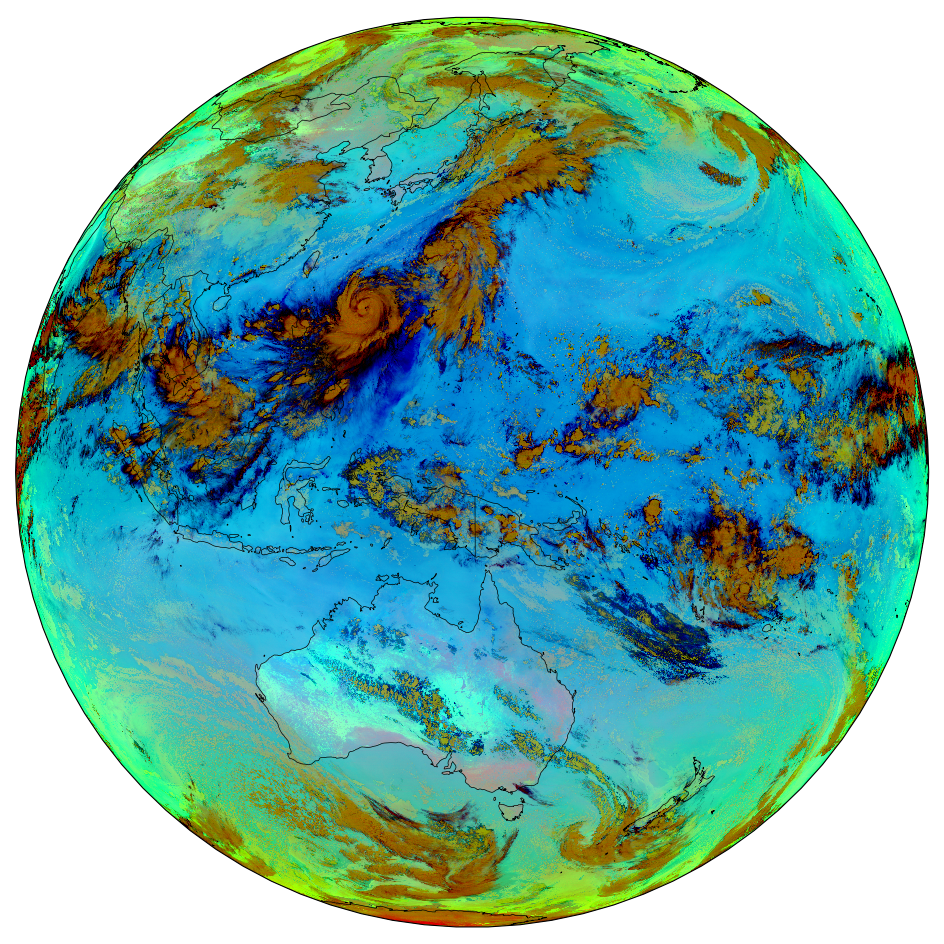

In [4]:
rgb, src_crs, src_extent = extract_himawari_visualization(da_h)

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection=src_crs)
ax.coastlines(resolution="50m", color="black", linewidth=0.5)
ax.add_feature(cfeature.BORDERS, edgecolor="black", linewidth=0.5)

ax.imshow(rgb, extent=src_extent, transform=src_crs, interpolation="none");

## GEO Mosaic

It's possible to stitch together GOES and Himawari imagery to create a near-global mosaic. While the corresponding bands are similar, they are not identical. This explains some of the color differences across the seam in the mosaic below.

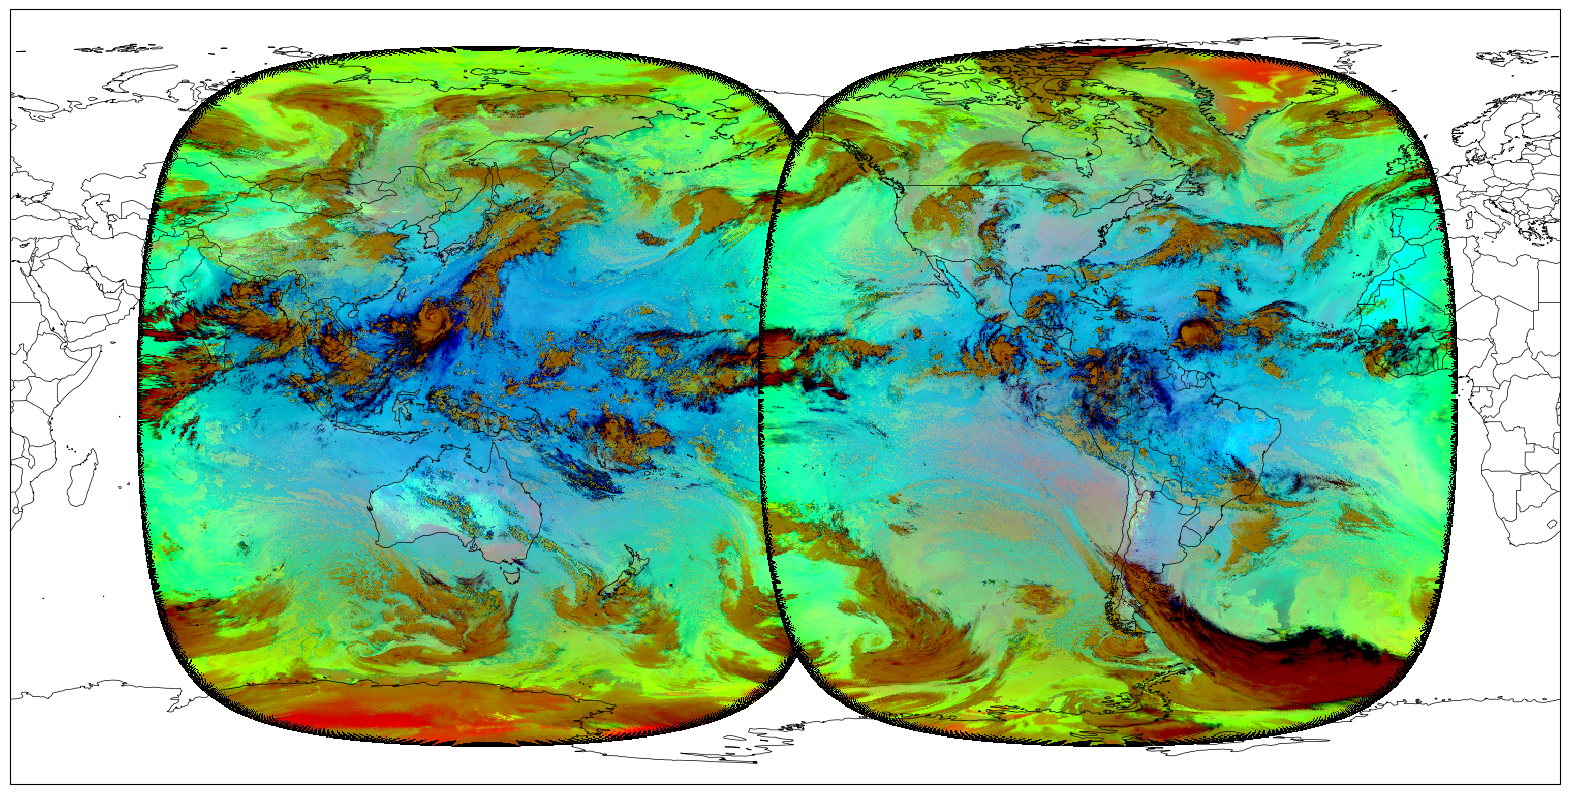

In [5]:
rgb_h, src_crs_h, src_extent_h = extract_himawari_visualization(da_h)
rgb_g, src_crs_g, src_extent_g = extract_goes_visualization(da_g)

dst_crs = ccrs.PlateCarree(central_longitude=-150.0)

fig = plt.figure(figsize=(20, 12))
ax = fig.add_subplot(projection=dst_crs)
ax.coastlines(resolution="50m", color="black", linewidth=0.5)
ax.add_feature(cfeature.BORDERS, edgecolor="black", linewidth=0.5)

ax.imshow(rgb_h, extent=src_extent_h, transform=src_crs_h, interpolation="none")
ax.imshow(rgb_g, extent=src_extent_g, transform=src_crs_g, interpolation="none");

## Himawari regional imagery

Himawari data is available for a Japan region (`region='J'`) and a dynamic target region (`region='T'`). Imagery over both are available every 2.5 minutes.

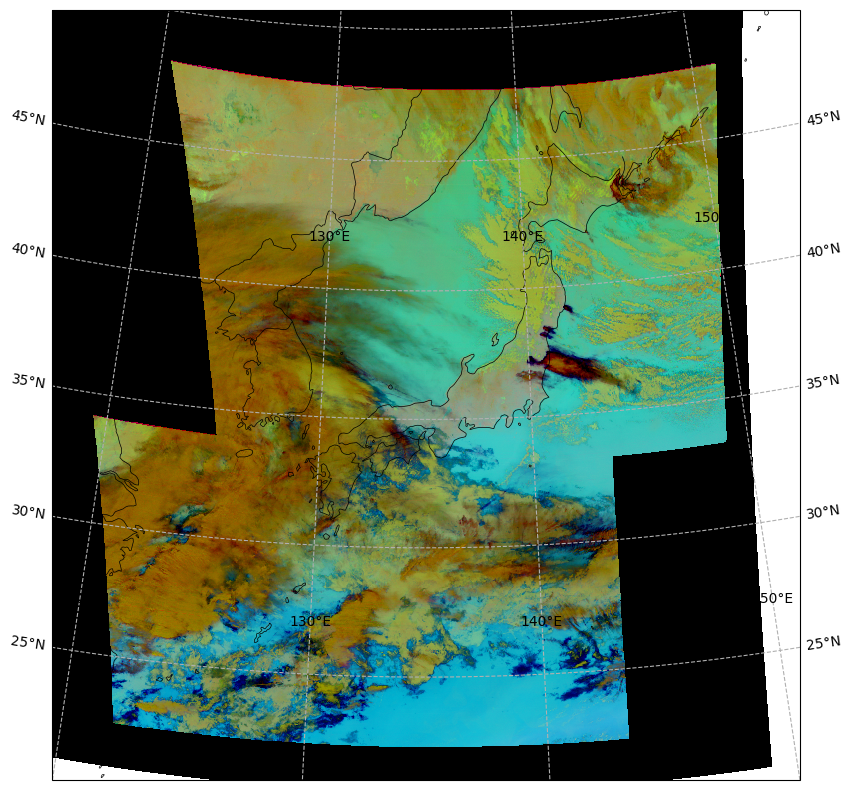

In [6]:
h = Himawari(region="Japan")
da_h = h.get("2025-03-14T15:00:00")

rgb, src_crs, src_extent = extract_himawari_visualization(da_h, color_scheme="ash")

dst_crs = ccrs.LambertConformal(
    central_longitude=135,
    central_latitude=35,
    standard_parallels=(30, 40),
)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection=dst_crs, extent=[120, 150, 20, 50])
ax.imshow(rgb, extent=src_extent, transform=src_crs, interpolation="none")
ax.coastlines(resolution="50m", color="black", linewidth=0.5)
ax.add_feature(cfeature.BORDERS, edgecolor="black", linewidth=0.5)

gl = ax.gridlines(draw_labels=True, linestyle="--");

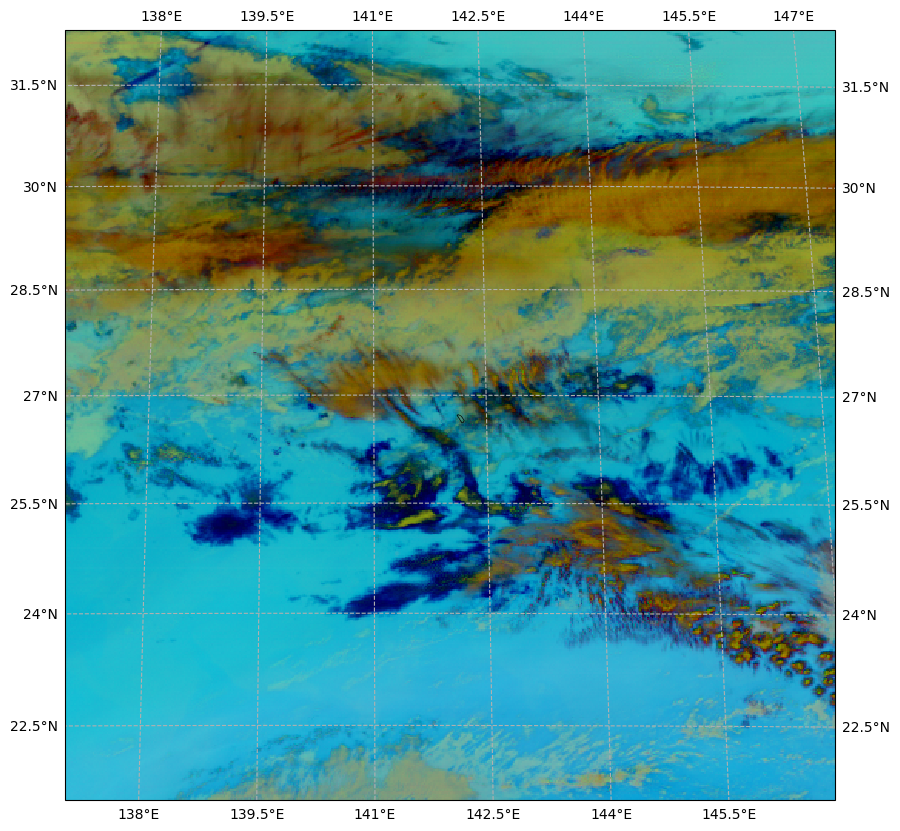

In [7]:
h = Himawari(region="Target")
da_h = h.get("2025-03-14T15:00:00")

rgb, src_crs, src_extent = extract_himawari_visualization(da_h, color_scheme="ash")

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection=src_crs)
ax.imshow(rgb, extent=src_extent, transform=src_crs, interpolation="none")
ax.coastlines(resolution="50m", color="black", linewidth=0.5)
ax.add_feature(cfeature.BORDERS, edgecolor="black", linewidth=0.5)

gl = ax.gridlines(draw_labels=True, linestyle="--")